In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm

import time
import os

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0
True


# Load CSV file and get labels

In [3]:
plt.ion()
csv_file = pd.read_csv('./Training_set_food.csv')

labels = list(dict.fromkeys(csv_file['label']))

# Data transformation and augmentation

In [4]:
#Data Transformation and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset and DataLoaders

In [5]:
data_dir = '/homes/ncho/comp4211/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

image_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=1) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda:0


# imshow function for tensor image

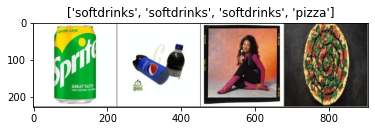

In [6]:
def imshow(imgs, title=None):
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(image_dataloader['train']))

imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

# Train function and its pipeline

In [7]:
def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True):
    last_loss = 100
    patience = 5
    trigger_times = 0
    
    total_start = time.time()
    
    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in tqdm(image_dataloader[phase]):
            for index, (inputs, labels) in enumerate(image_dataloader[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]
            
            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
            if phase == 'val':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)

            print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())
            
            if early_stopping and phase == 'val':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss
                else:
                    trigger_times = 0
                last_loss = epoch_loss
        
        #save on every 10 epochs
        if epoch % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, '/homes/ncho/comp4211/weights/ResNet18_epoch_{}.pt'.format(epoch))

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)
    return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss

# Visualization for validation set

In [8]:
def visualize_model(model, num_imgs=4):
    train_phase = model.training
    model.eval()
    total_images_processed = 0
    fig = plt.figure()

    with torch.no_grad():
        #for inputs, labels in tqdm(image_dataloader['val']):
        for index, (inputs, labels) in enumerate(image_dataloader['val']):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                total_images_processed += 1
                ax = plt.subplot(num_imgs//2, 2, total_images_processed)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if total_images_processed == num_imgs:
                    model.train(mode=train_phase)
                    return
        model.train(mode=train_phase)

# Network Structure

In [9]:
#Load pretrained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train

In [10]:
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
                                                                                          learning_rate_scheduler, num_epochs=500, early_stopping=True)

Epoch 0 / 499
--------------------
train Loss: 1.54465 Accuracy: 0.75079
val Loss: 0.56502 Accuracy: 0.90556
Epoch 0: 60.737s

Epoch 1 / 499
--------------------
train Loss: 1.45665 Accuracy: 0.79233
val Loss: 0.42113 Accuracy: 0.93519
Epoch 1: 44.834s

Epoch 2 / 499
--------------------
train Loss: 1.39468 Accuracy: 0.80132
val Loss: 0.47700 Accuracy: 0.92870
Epoch 2: 44.919s

Epoch 3 / 499
--------------------
train Loss: 1.63014 Accuracy: 0.80159
val Loss: 0.50116 Accuracy: 0.92963
Epoch 3: 46.541s

Epoch 4 / 499
--------------------
train Loss: 1.35685 Accuracy: 0.81931
val Loss: 0.45551 Accuracy: 0.93796
Epoch 4: 47.111s

Epoch 5 / 499
--------------------
train Loss: 1.44600 Accuracy: 0.80291
val Loss: 0.65151 Accuracy: 0.90926
Epoch 5: 48.218s

Epoch 6 / 499
--------------------
train Loss: 1.43776 Accuracy: 0.80132
val Loss: 1.09186 Accuracy: 0.86759
Epoch 6: 44.743s

Epoch 7 / 499
--------------------
train Loss: 1.51936 Accuracy: 0.80794
val Loss: 0.60092 Accuracy: 0.91111
Ep

## Graph for accuracy and loss

<Figure size 432x288 with 0 Axes>

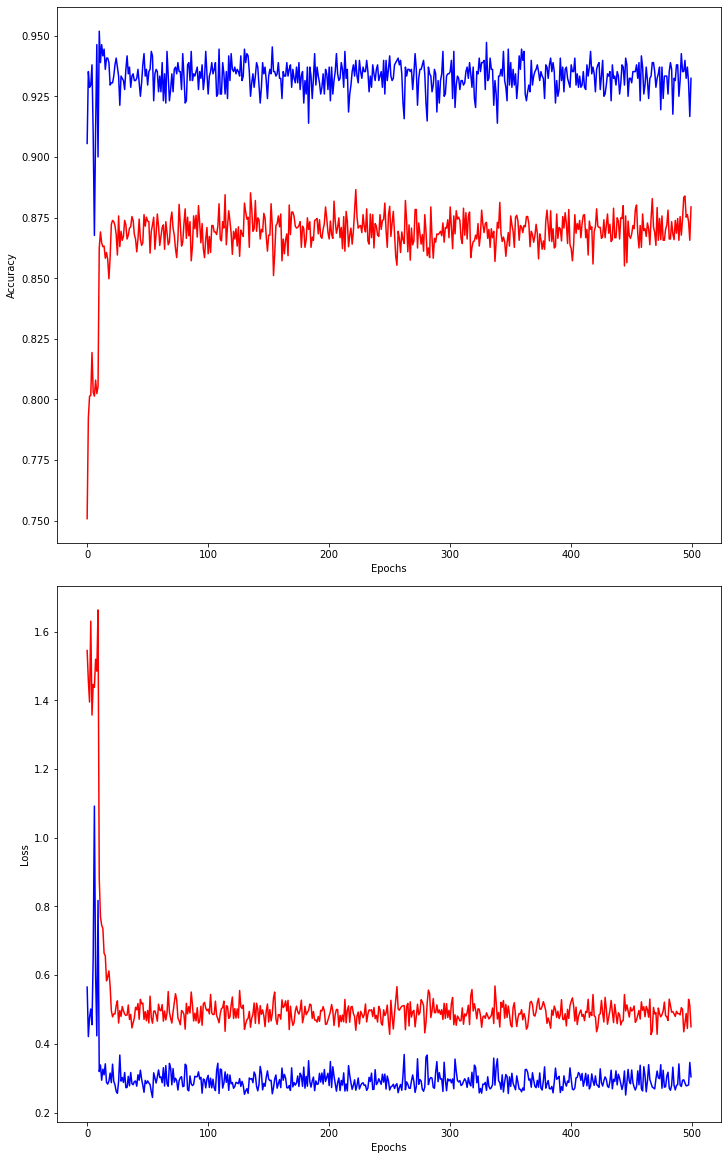

In [11]:
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)

total_train_accuracy = torch.Tensor(total_train_accuracy).cpu()
total_val_accuracy = torch.Tensor(total_val_accuracy).cpu()
total_train_loss = torch.Tensor(total_train_loss).cpu()
total_val_loss = torch.Tensor(total_val_loss).cpu()

axs[0].plot(total_train_accuracy, 'r-', label='train accuracy')
axs[0].plot(total_val_accuracy, 'b-', label='val accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(total_train_loss, 'r-', label='train loss')
axs[1].plot(total_val_loss, 'b-', label='val loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.show()

## Visualize some validation set prediction results

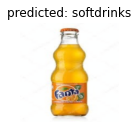

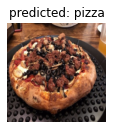

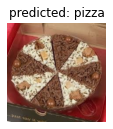

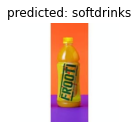

In [12]:
visualize_model(model, num_imgs=4)

plt.ioff()
plt.show()

## Save final model

In [13]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion
}, '/homes/ncho/comp4211/weights/ResNet18_final.pt')